<a href="https://colab.research.google.com/github/knattarina/wildfire_challenge/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import os
import numpy as np
import pandas as pd
import time
import random
from google.colab import drive

from matplotlib import pyplot
from collections import deque
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [97]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

df_all = pd.read_csv('Cleansed_Data.csv')
df_all['Date'] = pd.to_datetime(df_all['Date'])

df_all = df_all.drop(columns=['Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power'], inplace=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
df_all.replace(['NSW', 'NT', 'QL', 'VI', 'SA', 'TA', 'WA'], [1,2,3,4,5,6,7], inplace=True)

df_all.replace(2021, 2020, inplace=True)

first_col = df_all.pop('Estimated_fire_area')
df_all.insert(0, 'Estimated_fire_area', first_col)

df_all

,Estimated_fire_area,Date,Region,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,SoilWaterContent_Max,SoilWaterContent_Mean,SoilWaterContent_Min,SoilWaterContent_Variance,SolarRadiation_Max,SolarRadiation_Mean,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance,Month,Year,Shrubs_inflame_risk,Herbaceous vegetation_inflame_risk,Cultivated and managed vegetation/agriculture (cropland)_inflame_risk,Herbaceous wetland_inflame_risk,"Closed forest, deciduous broad leaf_inflame_risk","Closed forest, unknown_inflame_risk","Open forest, deciduous broad leaf_inflame_risk","Open forest, unknown definitions_inflame_risk"
0,8.68000,2005-01-04,1,22.842566,2.808620,0.000000,17.383363,90.332771,57.095628,31.279930,267.158378,0.444927,0.214293,0.022578,0.009965,33.214062,22.617291,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301,0.349996,0.995264,-0.2,0.205230,0.042121,1,2005,4.030027,28.340191,8.450057,0.065000,4.420030,0.195001,2.405016,6.695045
1,16.61125,2005-01-05,1,7.657155,0.157935,0.000000,0.273471,88.623436,47.170735,24.466665,195.639724,0.442955,0.203951,0.019950,0.009483,33.554867,28.076835,14.087289,29.763055,29.510120,22.425765,9.611800,13.352380,7.091141,4.014080,1.011328,1.043316,0.350260,0.994619,-0.2,0.205353,0.042172,1,2005,4.028387,28.328657,8.446618,0.064974,4.418231,0.194922,2.404037,6.692320
2,5.52000,2005-01-06,1,27.616505,0.434833,0.000000,4.634465,92.850960,39.874638,21.705952,213.300558,0.431879,0.193668,0.020037,0.008750,34.075787,30.561703,12.310518,22.667707,26.982698,20.621405,9.024039,11.764178,9.905821,4.477879,0.930842,1.953685,0.350525,0.993974,-0.2,0.205476,0.042222,1,2005,4.026747,28.317123,8.443179,0.064948,4.416432,0.194843,2.403059,6.689596
3,6.26400,2005-01-07,1,3.839235,0.064224,0.000000,0.038927,79.103134,39.279410,16.215517,245.624576,0.418513,0.183778,0.018115,0.007799,34.019218,32.143718,16.044561,6.949267,24.752069,19.632722,8.691216,7.940373,10.446799,4.017578,1.601724,1.102751,0.350789,0.993329,-0.2,0.205599,0.042273,1,2005,4.025107,28.305589,8.439740,0.064921,4.414633,0.194763,2.402080,6.686871
4,5.40000,2005-01-08,1,2.866673,0.203352,0.000000,0.236269,83.001541,42.400824,14.008522,342.996833,0.413370,0.175935,0.014398,0.007482,33.265091,29.347715,15.209880,27.822830,26.472469,21.477315,10.821342,12.063971,6.671862,3.884550,1.167861,0.774612,0.351054,0.992684,-0.2,0.205722,0.042324,1,2005,4.023467,28.294055,8.436301,0.064895,4.412834,0.194684,2.401101,6.684146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41019,0.00000,2021-01-16,4,3.792535,0.554120,0.000000,1.603508,88.023066,62.733739,38.652317,138.596141,0.396825,0.208097,0.000000,0.005315,31.915091,25.202597,9.139078,42.739870,23.745773,18.655919,13.331279,7.428182,7.187792,3.794547,0.768036,2.455491,0.464405,0.958900,-0.2,0.210041,0.044117,1,2020,0.749833,18.745823,12.479362,0.160678,2.035261,0.160678,1.446106,2.785094
41020,0.00000,2021-01-17,4,6.843638,1.333216,0.030928,5.039375,82.593653,59.022712,40.612686,102.973965,0.395019,0.205052,0.000000,0.005281,30.587180,22.788965,14.921868,14.016861,25.078058,19.714281,13.921086,7.129170,8.091362,4.134014,0.689601,2.525525,0.464405,0.958900,-0.2,0.210041,0.044117,1,2020,0.749833,18.745823,12.479362,0.160678,2.035261,0.160678,1.446106,2.785094
41021,1.00000,2021-01-18,4,2.398288,0.120829,0.000000,0.063535,80.715721,60.200831,41.111980,102.314777,0.393214,0.202007,0.000000,0.005246,32.507900,28.730524,18.520205,15.245966,22.150974,17.403762,11.775290,6.100233,13.024096,5.066601,2.11

In [99]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 7  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "QL"

main_df = df_all#[df_all['Region'] == RATIO_TO_PREDICT].copy()

dates = main_df[['Date']]
main_df.drop(columns = ['Date'], inplace = True)#, 'Region'

In [100]:
## here, split away some slice of the future data from the main main_df.
times = sorted(main_df.index.values)
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]

main_df = main_df.sample(n = main_df.shape[0])
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]
main_df.dropna(inplace=True)
scaler = MinMaxScaler()
for col in main_df:#.columns.drop('Estimated_fire_area'):
  main_df[[col]] = scaler.fit_transform(main_df[[col]])
  validation_main_df[[col]] = scaler.fit_transform(validation_main_df[[col]])

npmain = np.asarray(main_df)
npvalmain = np.asarray(validation_main_df)

train_x = npmain[:,1:]
train_y = npmain[:,0:1].ravel()

validation_x = npvalmain[:,1:]
validation_y = npvalmain[:,0:1].ravel()

train_x = scaler.fit_transform(train_x)

In [108]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 300, random_state = 42)# Train the model on training data
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [109]:
# Use the forest's predict method on the test data
predictions = rf.predict(validation_x)# Calculate the absolute errors
errors = abs(predictions - validation_y)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.06 degrees.


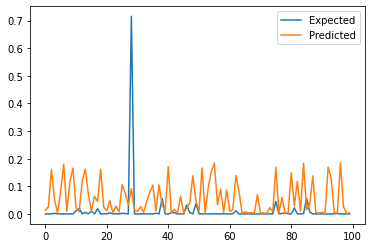

In [111]:
from matplotlib import pyplot

#pyplot.plot(errors, label = 'Expected')
pyplot.plot(validation_y[:100], label = 'Expected')
pyplot.plot(predictions[:100], label = 'Predicted')
pyplot.legend()
pyplot.show()

In [105]:
features = main_df.drop(columns=['Estimated_fire_area'], inplace=True)
feature_names = main_df.columns

In [106]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
#tree = rf.estimators_[5]# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest

#tree = rf.estimators_[5]# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
#graph.write_png('tree.png')

In [112]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Open forest, deciduous broad leaf_inflame_risk Importance: 0.13
Variable: Month                Importance: 0.11
Variable: SoilWaterContent_Max Importance: 0.1
Variable: Year                 Importance: 0.07
Variable: Vegetation_index_min Importance: 0.05
Variable: SoilWaterContent_Mean Importance: 0.03
Variable: SolarRadiation_Mean  Importance: 0.03
Variable: Vegetation_index_mean Importance: 0.03
Variable: Vegetation_index_max Importance: 0.03
Variable: Vegetation_index_variance Importance: 0.03
Variable: Cultivated and managed vegetation/agriculture (cropland)_inflame_risk Importance: 0.03
Variable: RelativeHumidity_Max Importance: 0.02
Variable: RelativeHumidity_Mean Importance: 0.02
Variable: RelativeHumidity_Variance Importance: 0.02
Variable: SoilWaterContent_Variance Importance: 0.02
Variable: SolarRadiation_Max   Importance: 0.02
Variable: SolarRadiation_Min   Importance: 0.02
Variable: Temperature_Max      Importance: 0.02
Variable: Temperature_Min      Importance: 0